In [ ]:
# Importing all necessary libraries required for this coursework

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

!pip install --upgrade spacy

In [ ]:
data = pd.read_csv('comp1804_dataset.csv')
data

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,clear_enough
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,not_clear_enough
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,clear_enough
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,clear_enough
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,not_clear_enough
...,...,...,...,...,...,...,...,...
9342,200523007578,Sir Joseph Dalton Hooker was a British botani...,ORG_YES_PRODUCT_NO_PERSON_YES_,54,16.0,man,biographies,NaN
9343,50634005203,As successful invasions of India generally cam...,ORG_YES_PRODUCT_NO_PERSON_YES_,217,46.0,woman,biographies,NaN
9344,6437003939,Hawking was born on 8 January 1942 in Oxford t...,ORG_YES_PRODUCT_NO_PERSON_YES_,91,27.0,woman,biographies,NaN
9345,725259002815,More complex tasks can be making custom data e...,ORG_YES_PRODUCT_NO_PERSON_NO_,47,15.0,man,programming,NaN


# Scatter Plots of Dataset Parameters

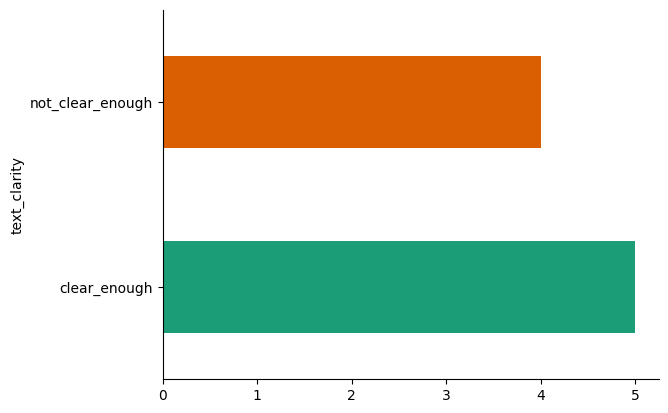

In [ ]:
# Scatter plot of 'text_clarity' parameter

data.groupby('text_clarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

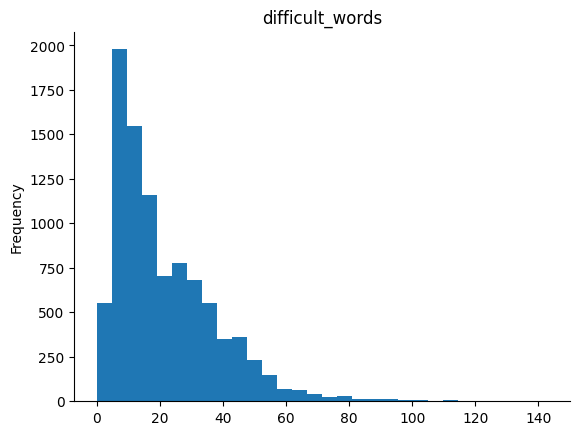

In [ ]:
# Scatter plot of 'difficult_words' parameter

data['difficult_words'].plot(kind='hist', bins=30, title='difficult_words')
plt.gca().spines[['top', 'right',]].set_visible(False)

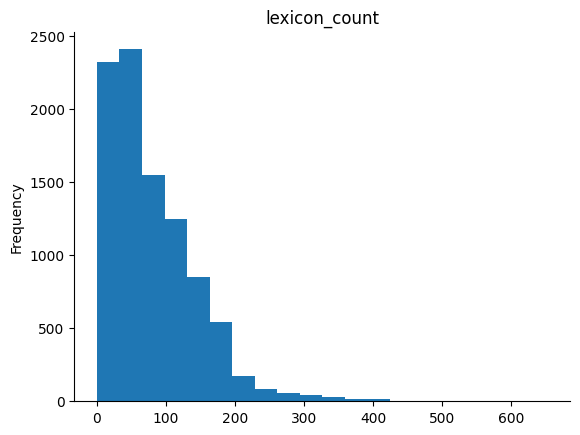

In [ ]:
# Scatter plot of 'lexicon_count' parameter

data['lexicon_count'].plot(kind='hist', bins=20, title='lexicon_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

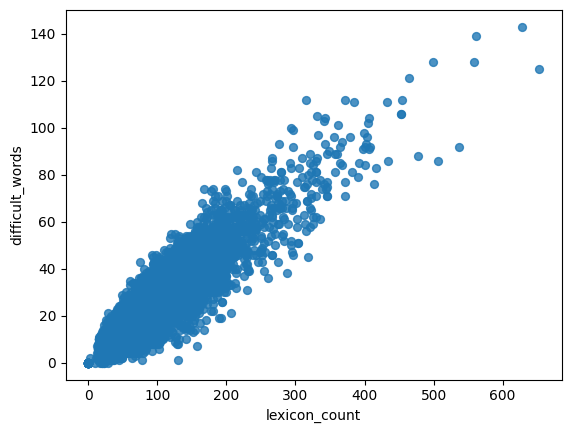

In [ ]:
# plot representation of 'lexicon_count' vs 'difficult_words'

data.plot(kind='scatter', x='lexicon_count', y='difficult_words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]]

<Axes: title={'center': 'Distribution of Target Variable'}, ylabel='Count'>

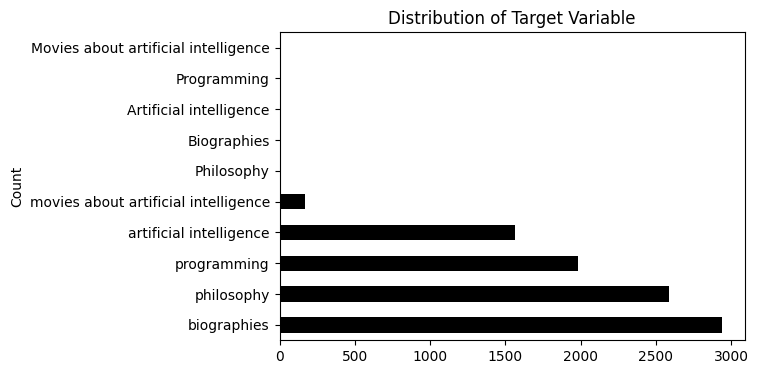

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Distribution of Target Variable')
plt.xlabel('Category')
plt.ylabel('Count')
data['category'].value_counts().plot(kind='barh', color='black')

# Statistics Summary


In [ ]:
data.shape

(9347, 8)

In [ ]:
data.ndim

2

In [ ]:
data.columns

Index(['par_id', 'paragraph', 'has_entity', 'lexicon_count', 'difficult_words',
       'last_editor_gender', 'category', 'text_clarity'],
      dtype='object')

In [ ]:
data.describe()

,par_id,lexicon_count,difficult_words
count,9.347000e+03,9347.000000,9329.000000
mean,3.568369e+11,81.981277,21.514203
std,3.221399e+11,63.533532,16.307358
min,8.500328e+07,0.000000,0.000000
25%,7.019601e+10,33.000000,9.000000
50%,2.684380e+11,64.000000,17.000000
75%,6.124310e+11,117.000000,30.000000
max,1.058779e+12,653.000000,143.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9347 entries, 0 to 9346
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              9347 non-null   int64  
 1   paragraph           9347 non-null   object 
 2   has_entity          9347 non-null   object 
 3   lexicon_count       9347 non-null   int64  
 4   difficult_words     9329 non-null   float64
 5   last_editor_gender  9347 non-null   object 
 6   category            9286 non-null   object 
 7   text_clarity        9 non-null      object 
dtypes: float64(1), int64(2), object(5)
memory usage: 584.3+ KB


# Handling and Imputing missing values

In [ ]:
## Checking for missing values in the target variable - we find there are 61 missing values
data.isnull().sum()

par_id                   0
paragraph                0
has_entity               0
lexicon_count            0
difficult_words         18
last_editor_gender       0
category                61
text_clarity          9338
dtype: int64

In [ ]:
# Imputing the 61 missing values found in the target variable
category_mode = data['category'].mode()[0]
data['category'].fillna(category_mode, inplace=True)

In [ ]:
# Validating that there are no missing values anymore in our target variable
data.isnull().sum()

par_id                   0
paragraph                0
has_entity               0
lexicon_count            0
difficult_words         18
last_editor_gender       0
category                 0
text_clarity          9338
dtype: int64

# Exploratory Data Analysis

<Axes: title={'center': 'Distribution of Target Variable'}, ylabel='Count'>

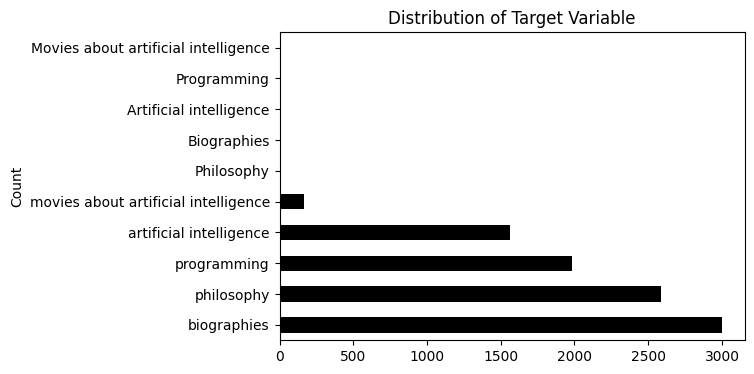

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Distribution of Target Variable')
plt.xlabel('Category')
plt.ylabel('Count')
data['category'].value_counts().plot(kind='barh', color='black')

<Axes: title={'center': 'Distribution of Target Variable'}, ylabel='Count'>

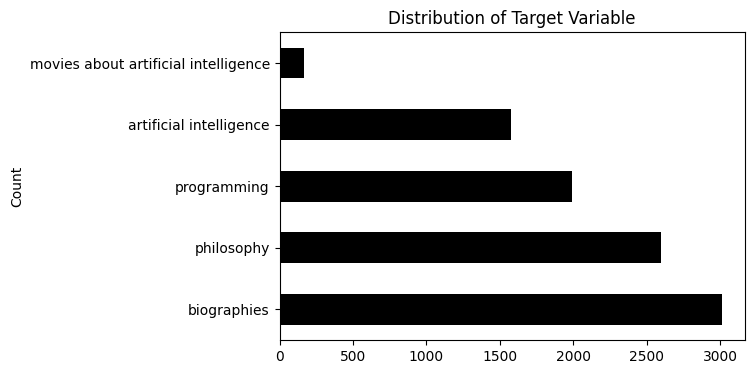

In [ ]:
# Removing parameters with 0 counts/values
plt.figure(figsize=(6,4))
data['category']=data['category'].str.lower()
plt.title('Distribution of Target Variable')
plt.xlabel('Category')
plt.ylabel('Count')
data['category'].value_counts().plot(kind='barh', color='black')

# Checking and dropping duplicates

In [ ]:
# Printing duplicate rows in the input parameter - 'paragraph'
data['paragraph']=data['paragraph'].str.lower()
clean_data = data.drop_duplicates(subset=['paragraph'])
print("Cleaned Dataset:")
print(clean_data.shape)

Cleaned Dataset:
(8992, 8)


In [ ]:
# Printing duplicate rows in the input parameter - 'has_entity'
data['has_entity']=data['has_entity'].str.lower()
clean_data = data.drop_duplicates(subset=['has_entity'])
print("Cleaned Dataset:")
print(clean_data.shape)

Cleaned Dataset:
(9, 8)


In [ ]:
# Printing duplicate rows in the target variable
data['category']=data['category'].str.lower()
clean_data = data.drop_duplicates(subset=['category'])
print('Duplicated Rows in Output Feature are:')
print(clean_data.shape)

Duplicated Rows in Output Feature are:
(5, 8)


# Reading and Splitting data

In [ ]:
# Selecting the features and target variable
X = data[['has_entity', 'paragraph']]
Y = data[['category']]

In [ ]:
print(X.isna().sum())
print(Y.isna().sum())
print(Y.value_counts())

has_entity    0
paragraph     0
dtype: int64
category    0
dtype: int64
category                            
biographies                             3016
philosophy                              2598
programming                             1990
artificial intelligence                 1576
movies about artificial intelligence     167
dtype: int64


In [ ]:
# Splitting data in the ratio 80:20% for training and testing
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)
print()
print(train_X.head(10))

(7477, 2)
(1870, 2)
(7477, 1)
(1870, 1)

                          has_entity  \
6443   org_yes_product_no_person_no_   
5846  org_yes_product_no_person_yes_   
7104   org_yes_product_no_person_no_   
251   org_yes_product_no_person_yes_   
8606   org_no_product_no_person_yes_   
7698   org_yes_product_no_person_no_   
8500  org_yes_product_no_person_yes_   
7700  org_yes_product_no_person_yes_   
7458  org_yes_product_no_person_yes_   
4202  org_yes_product_no_person_yes_   

                                              paragraph  
6443  extension of the bank to the north-west, the e...  
5846  thomson's separation of neon isotopes by their...  
7104  the python license was an open-source, gpl-com...  
251    now let's be clear before we go any further t...  
8606  a general system of botany, descriptive and an...  
7698  the bahaʼi faith asserts that evil is non-exis...  
8500  in august 1993, it was discovered that the pro...  
7700  roko's basilisk has gained a significant amoun..

# Encoding the categorical data

In [ ]:
# Using Label Encoder for encoding the categorical data
label_encoder = LabelEncoder()
train_Y_encoded = label_encoder.fit_transform(train_Y)
test_Y_encoded = label_encoder.transform(test_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
## Text Vectorization
vectorizer = TfidfVectorizer()
train_X_vector = vectorizer.fit_transform(train_X['paragraph'])
test_X_vector = vectorizer.transform(test_X['paragraph'])

# Model Training

In [ ]:
# Setting up the Multinomial Logistic Regression Classifier
multinomial_logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

# Training the Model
multinomial_logistic_regression.fit(train_X_vector, train_Y)

# Making Predictions with Multinomial Logistic Regression
pred_Y_multinomial = multinomial_logistic_regression.predict(test_X_vector)

# Reshaping the test_Y variable
test_Y_reshaped = test_Y.values.ravel()

# Displaying Accuracy
accuracy_multinomial = accuracy_score(test_Y, pred_Y_multinomial)
print(f'Accuracy with Multinomial Logistic Regression: {accuracy_multinomial:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy with Multinomial Logistic Regression: 0.92


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Define the hyperparameters grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2']                # Regularization penalty
}

# Instantiate the grid search
grid_search = GridSearchCV(estimator=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42),
                           param_grid=param_grid,
                           cv=5,              # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1)         # Use all available CPU cores

# Fit the grid search to the data
grid_search.fit(train_X_vector, train_Y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
pred_Y_best = best_model.predict(test_X_vector)

# Calculate accuracy with the best model
accuracy_best = accuracy_score(test_Y, pred_Y_best)
print(f'Accuracy with Multinomial Logistic Regression (Best Model): {accuracy_best:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Hyperparameters: {'C': 100, 'penalty': 'l2'}
Accuracy with Multinomial Logistic Regression (Best Model): 0.93


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Confusion Matrix

In [ ]:
# Computing Confusion Matrix
con_matrix = confusion_matrix(test_Y, pred_Y_best)

# Displaying Confusion Matrix
print("Confusion Matrix:")
print(con_matrix)

Confusion Matrix:
[[301  15   0  10   9]
 [  5 541   0  27   3]
 [  0   5  32   0   1]
 [  7  20   0 481   5]
 [ 10   8   0   4 386]]


# Classification Report

In [ ]:
class_report = classification_report(test_Y, pred_Y_best)
print("Classification Report:")
print(class_report)

Classification Report:
                                      precision    recall  f1-score   support

             artificial intelligence       0.93      0.90      0.91       335
                         biographies       0.92      0.94      0.93       576
movies about artificial intelligence       1.00      0.84      0.91        38
                          philosophy       0.92      0.94      0.93       513
                         programming       0.96      0.95      0.95       408

                            accuracy                           0.93      1870
                           macro avg       0.95      0.91      0.93      1870
                        weighted avg       0.93      0.93      0.93      1870



In [ ]:
precision = precision_score(test_Y, pred_Y_best, average='weighted')
recall = recall_score(test_Y, pred_Y_best, average='weighted')
f1 = f1_score(test_Y, pred_Y_best, average='weighted')
print(f'Weighted Precision: {precision:.2f}')
print(f'Weighted Recall: {recall:.2f}')
print(f'Weighted F1-score: {f1:.2f}')

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93


In [ ]:
# Creating a DummyClassifier with strategy 'most_frequent'
dummy_clf = DummyClassifier(strategy="most_frequent")

# Training the DummyClassifier on the training data
dummy_clf.fit(train_X, train_Y)

# Predicting the majority class for all samples in the test set
baseline_pred = dummy_clf.predict(test_X)

# Calculating the accuracy of the trivial baseline
baseline_accuracy = accuracy_score(test_Y, baseline_pred)
print("Trivial Baseline Accuracy:", baseline_accuracy)

NameError: name 'DummyClassifier' is not defined